In [1]:
#Load relevant pacakages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
import os, sys, glob, yaml, datetime, argparse
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
#Grab some relevant part of tools.py in qtrkx-gnn-tracking
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)

In [3]:
def parse_args():
    # generic parser, nothing fancy here
    parser = argparse.ArgumentParser(description='Load config file!')
    add_arg = parser.add_argument
    add_arg('config')
    add_arg('RID')
    return parser.parse_args()
def load_config(args):
    # read the config file 
    with open(args.config, 'r') as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.FullLoader)
        if len(glob.glob(config['log_dir']))==0:
            os.mkdir(config['log_dir'])
        # append RID to log dir
        config['log_dir'] = config['log_dir']+'run{}/'.format(args.RID)
        if len(glob.glob(config['log_dir']))==0:
            os.mkdir(config['log_dir'])
        # print all configs
        print('Printing configs: ')
        for key in config:
            print(key + ': ' + str(config[key]))
        print('Log dir: ' + config['log_dir'])
        print('Training data input dir: ' + config['train_dir'])
        print('Validation data input dir: ' + config['train_dir'])
        if config['run_type'] == 'new_run':
            delete_all_logs(config['log_dir'])
    # LOG the config every time
    with open(config['log_dir'] + 'config.yaml', 'w') as f:
        for key in config:
            f.write('%s : %s \n' %(key,str(config[key])))
    # return the config dictionary
    return config

In [4]:
#We will use this in the modified tools.py
def load_graph_(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        temp=dict(f.items())
    X, y, Ri_rows, Ri_cols, Ro_rows, Ro_cols = temp['X'],temp['y'],temp['Ri_rows'],temp['Ri_cols'],temp['Ro_rows'],temp['Ro_cols']
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), np.float32)
    Ro = np.zeros((n_nodes, n_edges), np.float32)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    #Need to change type for later use.
    y,Ri,Ro=y.astype(np.int32),Ri.astype(np.int32),Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = n_nodes, n_edges
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    for k in range(NE):
        if k>0 and k%2000==0: 
            print(k,'-th iteration..')
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
                            neighbors[i].append(j)

    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    # Concatenate the two arrays horizontally (along columns)
    coloring = np.reshape(coloring,(-1,1))
    X = np.concatenate((X, coloring), axis=1)
    return Graph(X, Ri, Ro, y)

In [ ]:
def load_graph2(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs2')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
#Coloring functions
def graph_coloring2(graph_name):
    graph_ex=load_graph2(graph_name)
    #Load raw data
    X = graph_ex.X
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    #Need to change type for later use.
    y=y.astype(np.int32)
    Ri = Ri.astype(np.int32)
    Ro = Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = Ri.shape
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    for k in range(NE):
        if k!=0 and k%3000==0:
            print(k,"-th iteration...")
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
                            neighbors[i].append(j)
    print("Start greedy coloring for "+graph_name)
    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    return X, y, Ri, Ro, coloring
#Data management functions
def save_color_df2(graph_name,folder):
    X, _, _, _, coloring = graph_coloring2(graph_name)
    X_color = color_df(X,coloring)
    #X_color_red = color_df_red(X,coloring)
    dir_ = os.path.join(os.getcwd(), folder)
    # Ensure that the 'dir_' directory exists; if not, create it
    if not os.path.exists(dir_):
        os.makedirs(dir_)
    # Specify the full file path, including the directory and filename
    graph_name_=graph_name[:-4]
    #graph_name_red = graph_name_+'_red'
    file_path = os.path.join(dir_, f"{graph_name_}.csv")
    #file_path_red = os.path.join(dir_, f"{graph_name_red}.csv")
    # Save the DataFrame as a CSV file
    X_color.to_csv(file_path, index=False)
    print("CSV file saved..")
    #X_color_red.to_csv(file_path_red, index=False)
graph_names2 = file_names("graphs2")

In [5]:
#Coloring functions
def graph_coloring(graph_name):
    graph_ex=load_graph(graph_name)
    #Load raw data
    X = graph_ex.X
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    #Need to change type for later use.
    y=y.astype(np.int32)
    Ri = Ri.astype(np.int32)
    Ro = Ro.astype(np.int32)
    # Get the number of nodes and edges
    NV, NE = Ri.shape
    # Initialize the coloring vector
    coloring = np.zeros(NV, dtype=int)
    # Create a dictionary to store the neighbors of each node
    neighbors = {i: [] for i in range(NV)}
    for k in range(NE):
        if k!=0 and k%3000==0:
            print(k,"-th iteration...")
        if y[k] == 1:
            for j in range(NV):
                if Ro[j, k] == 1:
                    for i in range(NV):
                        if Ri[i, k] == 1 and i != j:
                            neighbors[j].append(i)
                            neighbors[i].append(j)
    print("Start greedy coloring for "+graph_name)
    # Greedy coloring
    for node in range(NV):
        used_colors = set(coloring[n] for n in neighbors[node])
        # Find the smallest unused color
        color = 0
        while color in used_colors:
            color += 1
        coloring[node] = color
    return X, y, Ri, Ro, coloring
#Include coloring to the original X data frame
def color_df(original_X,color):
    X_color = pd.DataFrame(original_X,columns=['x','y','z'])
    X_color['color'] = color
    return X_color
#If there are too many data points, reduce.
def color_df_red(original_X,color):
    X_color=color_df(original_X,color)
    X_color['r'] = np.sqrt(X_color['x']**2 + X_color['y']**2)
    X_color_red=X_color[(X_color['z']<0.1)&(X_color['z']>-0.1)
                   &(X_color['y']>0)&(X_color['r']<0.2)]
    return X_color_red

In [17]:
#Plotting functions
def plot3d(df,st):
    df = pd.DataFrame(df)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    # Replace 'x', 'y', 'z', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    z = df['z']
    label = df[st]
    scatter = ax.scatter(x, y, z, c=label, cmap='viridis', s=25)
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Label')
    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    # Show the plot
    plt.show()
def plot2d(df,st):
    # Replace 'x', 'y', and 'label' with the actual column names in your DataFrame
    x = df['x']
    y = df['y']
    labels = df[st]
    # Create a scatter plot with colors based on the 'label' column
    plt.scatter(x, y, c=labels, cmap='viridis', s=25)
    # Add a colorbar to show the mapping of labels to colors
    colorbar = plt.colorbar()
    colorbar.set_label('Label')
    # Set labels for the axes
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    # Show the plot
    plt.show()
def plot_graph(graph_name):
    graph_ex=load_graph(graph_name)
    #Load raw data
    X = graph_ex.X
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    NV,NE = Ri.shape
    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=X[:, 0],
        y=X[:, 1],
        z=X[:, 2],
        mode='markers',
        marker=dict(
            size=1,  # Adjust the size of nodes
            opacity=0.8,
            color='red'  # Color of nodes
        )
    )])
    # Add directed edges to the plot using both Ri and Ro
    for k in range(NE):
        if y[k]==1:
            for i in range(NV):
                for j in range(i+1,NV):
                    if Ri[i,k]==1 or Ro[j, k] == 1:
                        x1, y1, z1 = X[i]
                        x2, y2, z2 = X[j]
                        fig.add_trace(go.Scatter3d(
                            x=[x1, x2],
                            y=[y1, y2],
                            z=[z1, z2],
                            mode='lines',
                            line=dict(
                                width=2,  # Adjust the width of edges
                                color='blue'  # Color of edges
                            )
                        ))

    # Show the plot
    fig.show()

In [72]:
# Prepare input for edge and node HNN 
def doublet_triplet(graph_name,d_or_t,e):
    graph_ex=load_graph(graph_name+'.npz')
    #Load raw data
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    y=graph_ex.y
    #Load colored X
    dir_ = os.path.join(os.getcwd(), 'data')
    file_path = os.path.join(dir_,graph_name+".csv")
    v = pd.read_csv(file_path)
    v = v.values #convert colored data frame to numpy array
    # Ri = (NV,NE), v = (NV,3+1)
    bo = np.matmul(Ri.T,v) 
    bi = np.matmul(Ro.T,v)
    #bo, bi = (NE, 3+1) : edge doublet
    if d_or_t=='doublet':
        # Concatenate the two arrays vertically (along rows)
        result = np.concatenate((bo, bi), axis=0)
        return result
    if d_or_t=='triplet':
        # Ri,Ro = (NV, NE), b = (NE,3+1), e = phi(bo + bi) = (NE,)
        # Perform the operation using Einstein summation notation
        vi = np.einsum('jk,k,k->j', Ri, e, bo)
        vo = np.einsum('jk,k,k->j', Ro, e, bi)
        #vi,vo,v = (NV, 3+1) : node triplet
        # Concatenate the three arrays vertically (along rows)
        result = np.concatenate((vi,v,vo), axis=0)
        return result

In [28]:
#Data management functions
def save_color_df(graph_name,folder):
    X, _, _, _, coloring = graph_coloring(graph_name)
    X_color = color_df(X,coloring)
    #X_color_red = color_df_red(X,coloring)
    dir_ = os.path.join(os.getcwd(), folder)
    # Ensure that the 'dir_' directory exists; if not, create it
    if not os.path.exists(dir_):
        os.makedirs(dir_)
    # Specify the full file path, including the directory and filename
    graph_name_=graph_name[:-4]
    #graph_name_red = graph_name_+'_red'
    file_path = os.path.join(dir_, f"{graph_name_}.csv")
    #file_path_red = os.path.join(dir_, f"{graph_name_red}.csv")
    # Save the DataFrame as a CSV file
    X_color.to_csv(file_path, index=False)
    print("CSV file saved..")
    #X_color_red.to_csv(file_path_red, index=False)
def file_names(folder):
    # Specify the directory path 
    graph_dir = os.path.join(os.getcwd(), folder)
    # Get a list of all files in the directory
    file_names = os.listdir(graph_dir)
    # filter out only files
    file_names = [f for f in file_names if os.path.isfile(os.path.join(graph_dir, f))]
    return file_names

In [29]:
graph_names = file_names("graphs")

In [41]:
graph_names.remove('.DS_Store')
len(graph_names)

50

In [43]:
#Creating colored data set
for graph_name in graph_names[12:]:
    save_color_df(graph_name,'color')

3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001039_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
9000 -th iteration...
Start greedy coloring for event000001006_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
9000 -th iteration...
Start greedy coloring for event000001094_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001033_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001044_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001076_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001077_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001048_g000.npz
CSV file saved..
3000 -th iteration...
6000 -th iteration...
Start greedy coloring fo

In [44]:
#Creating colored test data set
for graph_name in graph_names2:
    save_color_df2(graph_name,'color2')

0 -th iteration...
3000 -th iteration...
Start greedy coloring for event000001067_g000.npz
CSV file saved..
0 -th iteration...
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001083_g000.npz
CSV file saved..
0 -th iteration...
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001058_g000.npz
CSV file saved..
0 -th iteration...
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001059_g000.npz
CSV file saved..
0 -th iteration...
3000 -th iteration...
6000 -th iteration...
9000 -th iteration...
Start greedy coloring for event000001038_g000.npz
CSV file saved..
0 -th iteration...
3000 -th iteration...
6000 -th iteration...
Start greedy coloring for event000001007_g000.npz
CSV file saved..
0 -th iteration...
3000 -th iteration...
6000 -th iteration...
9000 -th iteration...
Start greedy coloring for event000001095_g000.npz
CSV file saved..
0 -th iteration...
3000 -th iteration...
6000 -th iteration...
Start

In [20]:
def color_X_read(graph_name):
    color_dir = os.path.join(os.getcwd(), 'color')
    # Construct the full path to the specified file
    full_path = os.path.join(color_dir, graph_name)
    colorX=pd.read_csv(full_path)
    return colorX

In [20]:
print("Coloring vector sum: ",coloring.sum(), ", y vector sum: ",y.sum())

Coloring vector sum:  3803 , y vector sum:  3803


In [21]:
X_color = color_df(X,coloring)
X_color_red = color_df_red(X,coloring)
print("Color included data frame: ",X_color.shape,
      "\n After reduction: ",X_color_red.shape)

Color included data frame:  (4739, 4) 
 After reduction:  (112, 5)


In [ ]:
#Full 3d graph for event000001000_g000.npz
plot_graph('event000001000_g000.npz')

In [22]:
X_color=color_X_read('event000001000_g000.csv')

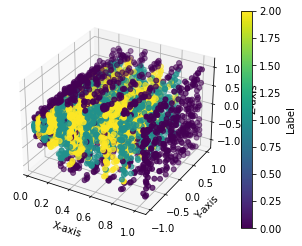

In [23]:
#Full 3d graphic for event000001000_g000.npz: 
plot3d(X_color,'color')

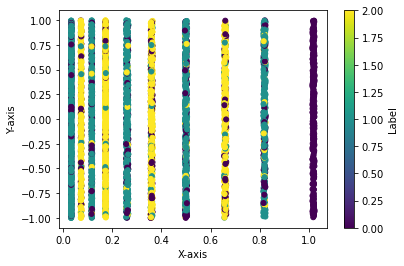

In [24]:
#Full 2d graphic for event000001000_g000.npz
plot2d(X_color,'color')

In [26]:
X_color=color_X_read('event000001006_g000.csv')

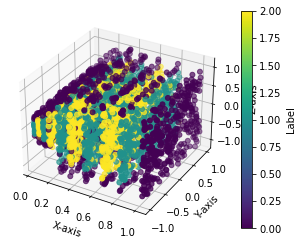

In [27]:
#Full 3d graphic for event000001006_g000.npz: 
plot3d(X_color,'color')

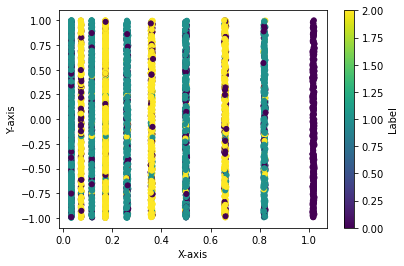

In [28]:
#Full 2d graphic for event000001006_g000.npz
plot2d(X_color,'color')

In [29]:
X_color = color_X_read('event000001010_g000.csv')

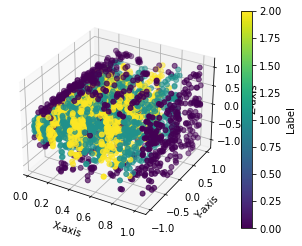

In [30]:
#Full 3d graphic for event000001010_g000.npz: 
plot3d(X_color,'color')

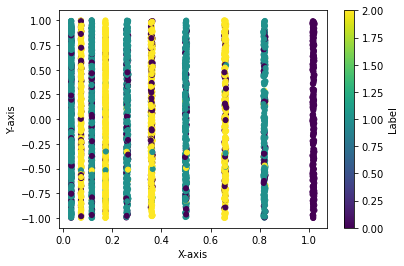

In [31]:
#Full 2d graphic for event000001010_g000.npz: 
plot2d(X_color,'color')

In [ ]:
#Creating colored data set for 10 graphs.
graph_names = file_names("graphs")
for graph_name in graph_names:
    save_color_df(graph_name,'data')